# Tuning Neural Networking in Keras

<a href="https://colab.research.google.com/github/coding-dojo-data-science/week-11-lecture-2-tuning-deep-learning-models/blob/main/SOLUTIONS%20Code-along%20Tuning%20Neural%20Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will use the version of Keras that comes in the Tensorflow package, as it has the most up to date tools.

Keras works as weapper for deep learning model to be used as classification or regression estimators in sklearn

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from seaborn import heatmap

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, \
classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# new libraries
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

# This is used to overcome an issue with setting up tensorflow in M1/M1
# Suspect tensorflow-macos not very fit with GPU, use CPU only with
tf.config.set_visible_devices([], 'GPU')

# Set random seeds for consistent outcomes
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## Useful Functions

In [2]:
def eval_regression(model, X, y, name='model'):
    """Returns a dataframe with regression metrics.
    optional name variable can be used to name each model and/or dataset used
    for clarity"""
    score_df = pd.DataFrame(index=[name])
    preds = model.predict(X)
    score_df.loc[name,'MAE'] = mean_absolute_error(y, preds)
    score_df.loc[name,'RMSE'] = np.sqrt(mean_squared_error(y, preds))
    score_df.loc[name,'R2'] = r2_score(y, preds)
    return score_df

def plot_history(history):
  """Takes a keras model learning history and plots each metric"""

  metrics = history.history.keys()

  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

# Data

We will be working with 2 different datasets in this project, 1 is a regression dataset and the other is a classification dataset.  This way you can practice doing both using deep learning.

**NOTE**

These datasets are very small for deep learning.  Deep learning models usually work best with very large datasets with at least 10,000 or more samples.  They work best on even larger datasets than that.  But, for demonstration we will use these smaller datasets.

## Regression
This is a dataset of housing prices in Boston from 1978.  Each row is a house and the dataset includes several features regarding each house.  Our target today will be the price of the home.



In [3]:
regression_df = pd.read_csv('Data/Boston_Housing_from_Sklearn.csv')

# Regression

Let's start with modeling the regression dataset

In [4]:
regression_df

,CRIM,NOX,RM,AGE,PTRATIO,LSTAT,PRICE
0,0.00632,0.538,6.575,65.2,15.3,4.98,24.0
1,0.02731,0.469,6.421,78.9,17.8,9.14,21.6
2,0.02729,0.469,7.185,61.1,17.8,4.03,34.7
3,0.03237,0.458,6.998,45.8,18.7,2.94,33.4
4,0.06905,0.458,7.147,54.2,18.7,5.33,36.2
...,...,...,...,...,...,...,...
501,0.06263,0.573,6.593,69.1,21.0,9.67,22.4
502,0.04527,0.573,6.120,76.7,21.0,9.08,20.6
503,0.06076,0.573,6.976,91.0,21.0,5.64,23.9
504,0.10959,0.573,6.794,89.3,21.0,6.48,22.0


In [7]:
regression_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   NOX      506 non-null    float64
 2   RM       506 non-null    float64
 3   AGE      506 non-null    float64
 4   PTRATIO  506 non-null    float64
 5   LSTAT    506 non-null    float64
 6   PRICE    506 non-null    float64
dtypes: float64(7)
memory usage: 27.8 KB


In [5]:
regression_df.duplicated().any()

False

In [6]:
regression_df.describe()

,CRIM,NOX,RM,AGE,PTRATIO,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,0.554695,6.284634,68.574901,18.455534,12.653063,22.532806
std,8.601545,0.115878,0.702617,28.148861,2.164946,7.141062,9.197104
min,0.006320,0.385000,3.561000,2.900000,12.600000,1.730000,5.000000
25%,0.082045,0.449000,5.885500,45.025000,17.400000,6.950000,17.025000
50%,0.256510,0.538000,6.208500,77.500000,19.050000,11.360000,21.200000
75%,3.677083,0.624000,6.623500,94.075000,20.200000,16.955000,25.000000
max,88.976200,0.871000,8.780000,100.000000,22.000000,37.970000,50.000000


In [8]:
# Define X and Y and complete the train test split
X = regression_df.drop(columns = 'PRICE')
y = regression_df['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

## Scaling

Always scale your data for deep learning.  Otherwise you get a problem call 'Exploding Weights'.  Some weights will be updated much faster than others because the inputs are at larger scales.  This tends to hurt learning as data on smaller scales does not update as fast and doesn't get to contribute as much to the decision making process.  By scaling we put all features on the same footing.

In [9]:
# Scale the data
scaler = MinMaxScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## First Simple Model

We always want to start simple, as deep learning models can get very complex fast and more complex models take more time to train and are more prone to overfitting.  A well performing simple model is better than a well performing complex model.

## Input layer
The first layer we will define is not technically the input layer.  We will define the first hidden layer with a special argument that tells Keras how to create a input layer:

`input_dim=`

Input layers can also be defined manually using tensorflow.keras.layers.InputLayer

## Activation function

For the single hidden layer we will try just 3 nodes and use a ReLU activation.  ReLUs tend to perform well for hidden nodes.

## Output Layer

For out output layer (last layer) we just use one node because we only want the output of the model to be one number.  We will use a linear activation function.  This will simply output the value from the weights and bias in the node with no change.  The output will be a continuous number, a float.  This will make our model a regression model.




In [10]:
# Check the shape of input

X_train.shape[1]

6

In [11]:
# Reset Random seed for consistency
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# use all features as input using input_dim
input_dim = X_train.shape[1]

# Instantiate your sequential model
reg_model1 = Sequential()

# Add first hidden layer
reg_model1.add(Dense(10, activation='relu', input_dim=input_dim, name='h1'))
# Add second hidden layer
reg_model1.add(Dense(10, activation='relu', name='h2'))

# Add output layer with 1 node
reg_model1.add(Dense(1, activation='linear', name ='output'))


# Check summary of network
reg_model1.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 10)                70        
                                                                 
 h2 (Dense)                  (None, 10)                110       
                                                                 
 output (Dense)              (None, 1)                 11        
                                                                 
Total params: 191 (764.00 Byte)
Trainable params: 191 (764.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Compiling

Compiling the model puts all the pieces together to make it ready to train.  We need to specify:

* **Optimizer:** An Adam optimizer is a favorite and often performs well, it's a good place to start.
  - Other optimizers : Gradient Descent,Stochastic Gradient Descent,Adagrad,RMSProp
* **Loss Function:** 'mse' or mean squared error.  This is the number our model will try to reduce in each epoch.  Since this is a regression model we want our model to minimize the mean squared error.
* **Metrics:** 'mae' or mean absolute error.  We can provide a list of any appropriate metrics we want the model to keep track at each epoch.




In [12]:
from tensorflow.keras.metrics import RootMeanSquaredError

In [13]:
# Compile your model.
rmse = RootMeanSquaredError(name='rmse')

reg_model1.compile(optimizer= 'adam', loss = 'mse', metrics= ['mae', rmse])

# Training

Let's try training our model for 100 few epochs.  Sometimes that is enough, and it will give us an idea whether our model is learning anything.

In [14]:
# Fit your model
history = reg_model1.fit(X_train, y_train,
                        validation_data = (X_test, y_test),
                        epochs = 100)

Epoch 1/100
12/12 [==============================] - 2s 34ms/step - loss: 615.4373 - mae: 22.9443 - rmse: 24.8080 - val_loss: 527.4907 - val_mae: 21.3847 - val_rmse: 22.9672
Epoch 2/100
12/12 [==============================] - 0s 9ms/step - loss: 609.8780 - mae: 22.8220 - rmse: 24.6957 - val_loss: 522.1560 - val_mae: 21.2585 - val_rmse: 22.8507
Epoch 3/100
12/12 [==============================] - 0s 9ms/step - loss: 604.2943 - mae: 22.6970 - rmse: 24.5824 - val_loss: 516.8129 - val_mae: 21.1301 - val_rmse: 22.7335
Epoch 4/100
12/12 [==============================] - 0s 11ms/step - loss: 598.6966 - mae: 22.5693 - rmse: 24.4683 - val_loss: 511.2976 - val_mae: 20.9958 - val_rmse: 22.6119
Epoch 5/100
12/12 [==============================] - 0s 8ms/step - loss: 592.8049 - mae: 22.4353 - rmse: 24.3476 - val_loss: 505.5936 - val_mae: 20.8555 - val_rmse: 22.4854
Epoch 6/100
12/12 [==============================] - 0s 8ms/step - loss: 586.6371 - mae: 22.2939 - rmse: 24.2206 - val_loss: 499.5633

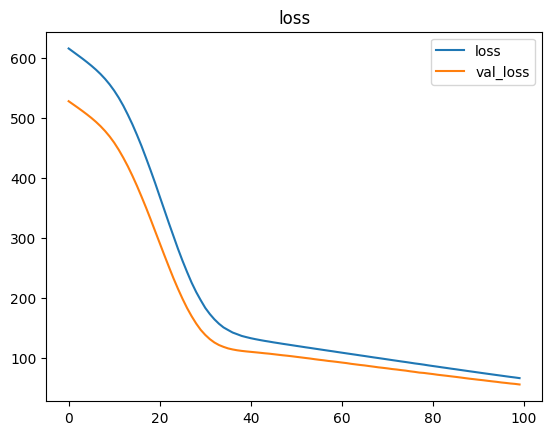

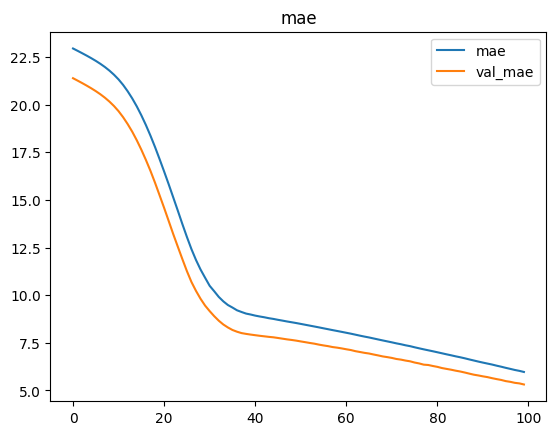

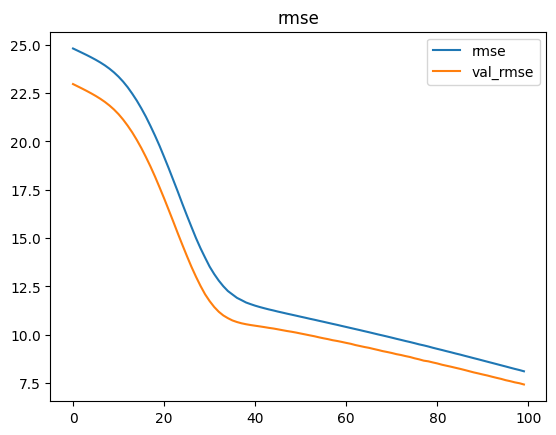

In [15]:
# Apply the custom function to see how your model is doing
plot_history(history)

## Evaluation


In [17]:
train_scores = eval_regression(reg_model1,
                         X_train,
                         y_train,
                         name='reg_model1 Train')

test_scores = eval_regression(reg_model1,
                                       X_test,
                                       y_test,
                                       name='reg_model1 Test')
scores = pd.concat([train_scores, test_scores])
scores

4/4 [==============================] - 0s 3ms/step


,MAE,RMSE,R2
reg_model1 Train,5.937423,8.072171,0.265238
reg_model1 Test,5.314461,7.426361,0.212436


# <center> Attack Bias or Variance? </center>

How should we tune this regression model?

# Improving ANN - 2nd Model

In [18]:
# Reset Random seed for consistency
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# use all features as input using input_dim
input_dim = X_train.shape[1]

# Instantiate your sequential model
reg_model2 = Sequential()

# Add first hidden layer
reg_model2.add(Dense(100, activation='relu', input_dim=input_dim, name='h1'))
# Add second hidden layer
reg_model2.add(Dense(100, activation='relu', name='h2'))

# Add output layer with 1 node
reg_model2.add(Dense(1, activation='linear', name ='output'))


# Check summary of network
reg_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 100)               700       
                                                                 
 h2 (Dense)                  (None, 100)               10100     
                                                                 
 output (Dense)              (None, 1)                 101       
                                                                 
Total params: 10901 (42.58 KB)
Trainable params: 10901 (42.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Compiling

Compiling the model puts all the pieces together to make it ready to train.  We need to specify:

* **Optimizer:** An Adam optimizer is a favorite and often performs well, it's a good place to start.
  - Other optimizers : Gradient Descent,Stochastic Gradient Descent,Adagrad,RMSProp
* **Loss Function:** 'mse' or mean squared error.  This is the number our model will try to reduce in each epoch.  Since this is a regression model we want our model to minimize the mean squared error.
* **Metrics:** 'mae' or mean absolute error.  We can provide a list of any appropriate metrics we want the model to keep track at each epoch.




In [19]:
# Compile your model.
rmse = RootMeanSquaredError(name='rmse')

reg_model2.compile(optimizer= 'adam', loss = 'mse', metrics= ['mae', rmse])

# Training

Let's try training our model for 100 few epochs.  Sometimes that is enough, and it will give us an idea whether our model is learning anything.

In [20]:
# Fit your model

history = reg_model2.fit(X_train, y_train,
                        validation_data = (X_test, y_test),
                        epochs = 100)


Epoch 1/100
12/12 [==============================] - 1s 19ms/step - loss: 592.8079 - mae: 22.4380 - rmse: 24.3476 - val_loss: 492.6412 - val_mae: 20.5108 - val_rmse: 22.1955
Epoch 2/100
12/12 [==============================] - 0s 7ms/step - loss: 555.3565 - mae: 21.5531 - rmse: 23.5660 - val_loss: 451.4409 - val_mae: 19.4190 - val_rmse: 21.2471
Epoch 3/100
12/12 [==============================] - 0s 6ms/step - loss: 499.8792 - mae: 20.1425 - rmse: 22.3580 - val_loss: 387.0557 - val_mae: 17.5585 - val_rmse: 19.6737
Epoch 4/100
12/12 [==============================] - 0s 5ms/step - loss: 417.0341 - mae: 17.8124 - rmse: 20.4214 - val_loss: 296.9296 - val_mae: 14.6464 - val_rmse: 17.2316
Epoch 5/100
12/12 [==============================] - 0s 5ms/step - loss: 307.5024 - mae: 14.4694 - rmse: 17.5357 - val_loss: 197.5620 - val_mae: 11.1195 - val_rmse: 14.0557
Epoch 6/100
12/12 [==============================] - 0s 7ms/step - loss: 203.1103 - mae: 11.1771 - rmse: 14.2517 - val_loss: 134.3665 

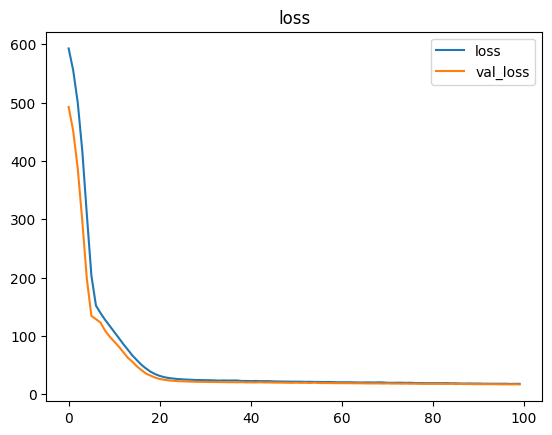

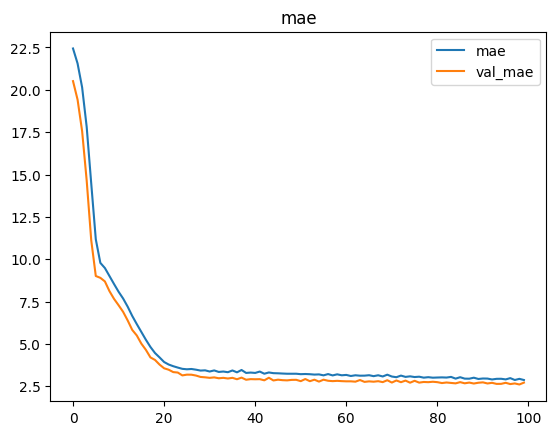

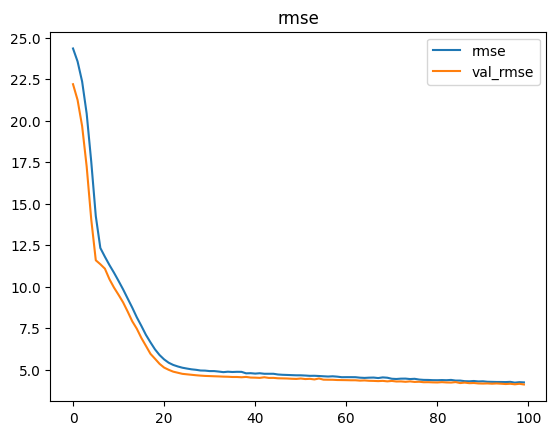

In [21]:
# Apply the custom function to see how your model is doing
plot_history(history)

## Evaluation


In [22]:
train_scores = eval_regression(reg_model2,
                         X_train,
                         y_train,
                         name='reg_model2 Train')
test_scores = eval_regression(reg_model2,
                                       X_test,
                                       y_test,
                                       name='reg_model2 test')
scores = pd.concat([scores, train_scores, test_scores])
scores

4/4 [==============================] - 0s 3ms/step


,MAE,RMSE,R2
reg_model1 Train,5.937423,8.072171,0.265238
reg_model1 Test,5.314461,7.426361,0.212436
reg_model2 Train,2.922909,4.209036,0.800230
reg_model2 test,2.718684,4.110663,0.758700


# <center> Attack Bias or Variance? </center>

How should we tune this regression model?

# Improving ANN - 3rd Model

In [23]:
# Reset Random seed for consistency
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# use all features as input using input_dim
input_dim = X_train.shape[1]

# Instantiate your sequential model
reg_model3 = Sequential()


# Add first hidden layer
reg_model3.add(Dense(10, activation='relu', input_dim=input_dim, name='h1'))
reg_model3.add(Dense(10, activation='relu', name='h2'))
reg_model3.add(Dense(10, activation='relu', name='h3'))
reg_model3.add(Dense(10, activation='relu', name='h4'))

# Add output layer with 1 node
reg_model3.add(Dense(1, activation='linear', name ='output'))


# Check summary of network
reg_model3.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 10)                70        
                                                                 
 h2 (Dense)                  (None, 10)                110       
                                                                 
 h3 (Dense)                  (None, 10)                110       
                                                                 
 h4 (Dense)                  (None, 10)                110       
                                                                 
 output (Dense)              (None, 1)                 11        
                                                                 
Total params: 411 (1.61 KB)
Trainable params: 411 (1.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Compiling

Compiling the model puts all the pieces together to make it ready to train.  We need to specify:

* **Optimizer:** An Adam optimizer is a favorite and often performs well, it's a good place to start.
  - Other optimizers : Gradient Descent,Stochastic Gradient Descent,Adagrad,RMSProp
* **Loss Function:** 'mse' or mean squared error.  This is the number our model will try to reduce in each epoch.  Since this is a regression model we want our model to minimize the mean squared error.
* **Metrics:** 'mae' or mean absolute error.  We can provide a list of any appropriate metrics we want the model to keep track at each epoch.




In [24]:
# Compile your model.
rmse = RootMeanSquaredError(name='rmse')

reg_model3.compile(optimizer= 'adam', loss = 'mse', metrics= ['mae', rmse])

# Training

Let's try training our model for 100 few epochs.  Sometimes that is enough, and it will give us an idea whether our model is learning anything.

In [25]:
# Fit your model
history = reg_model3.fit(X_train, y_train,
                        validation_data = (X_test, y_test),
                        epochs = 100)

Epoch 1/100
12/12 [==============================] - 1s 22ms/step - loss: 613.3577 - mae: 22.9098 - rmse: 24.7661 - val_loss: 525.7803 - val_mae: 21.3502 - val_rmse: 22.9299
Epoch 2/100
12/12 [==============================] - 0s 5ms/step - loss: 608.4970 - mae: 22.7997 - rmse: 24.6677 - val_loss: 521.3940 - val_mae: 21.2422 - val_rmse: 22.8341
Epoch 3/100
12/12 [==============================] - 0s 7ms/step - loss: 603.3547 - mae: 22.6815 - rmse: 24.5633 - val_loss: 516.0771 - val_mae: 21.1103 - val_rmse: 22.7173
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: 596.7785 - mae: 22.5301 - rmse: 24.4291 - val_loss: 508.9879 - val_mae: 20.9370 - val_rmse: 22.5608
Epoch 5/100
12/12 [==============================] - 0s 7ms/step - loss: 588.0250 - mae: 22.3318 - rmse: 24.2492 - val_loss: 499.7411 - val_mae: 20.7100 - val_rmse: 22.3549
Epoch 6/100
12/12 [==============================] - 0s 7ms/step - loss: 576.4263 - mae: 22.0653 - rmse: 24.0089 - val_loss: 487.3505 

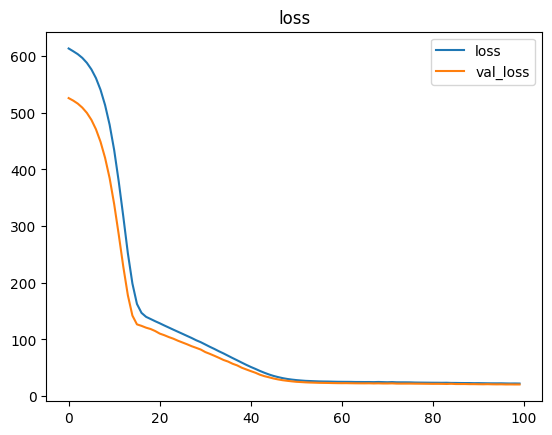

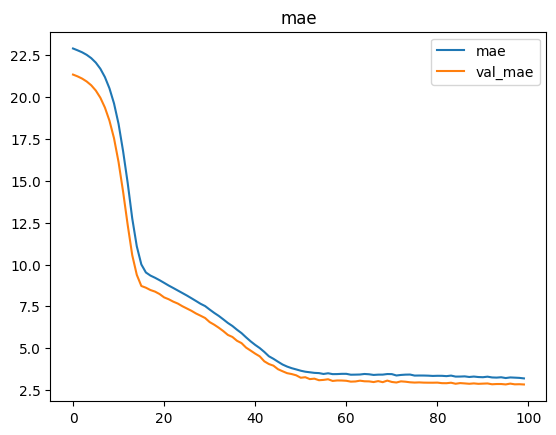

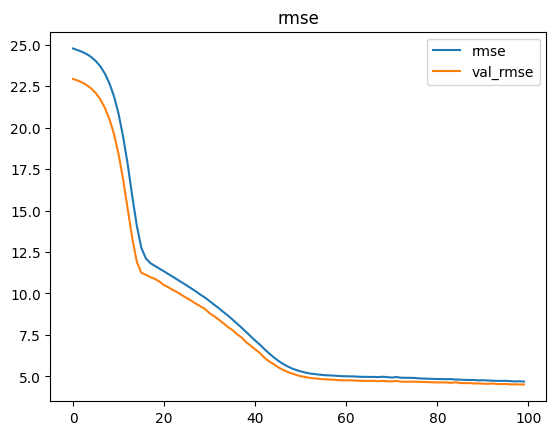

In [26]:
# Apply the custom function to see how your model is doing
plot_history(history)

## Evaluation


In [27]:
train_scores = eval_regression(reg_model3,
                         X_train,
                         y_train,
                         name='reg_model3 Train')
test_scores = eval_regression(reg_model3,
                                       X_test,
                                       y_test,
                                       name='reg_model3 test')
scores = pd.concat([scores, train_scores, test_scores])
scores

4/4 [==============================] - 0s 3ms/step


,MAE,RMSE,R2
reg_model1 Train,5.937423,8.072171,0.265238
reg_model1 Test,5.314461,7.426361,0.212436
reg_model2 Train,2.922909,4.209036,0.800230
reg_model2 test,2.718684,4.110663,0.758700
reg_model3 Train,3.186969,4.672947,0.753766
reg_model3 test,2.830452,4.515749,0.708799


# <center> Attack Bias or Variance? </center>

How should we tune this regression model?

# Improving ANN - 4th Model

In [28]:
# Reset Random seed for consistency
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# use all features as input using input_dim
input_dim = X_train.shape[1]

# Instantiate your sequential model
reg_model4 = Sequential()


# Add first hidden layer
reg_model4.add(Dense(100, activation='relu', input_dim=input_dim, name='h1'))
reg_model4.add(Dense(100, activation='relu', name='h2'))
reg_model4.add(Dense(100, activation='relu', name='h3'))
reg_model4.add(Dense(10, activation='relu', name='h4'))

# Add output layer with 1 node
reg_model4.add(Dense(1, activation='linear', name ='output'))


# Check summary of network
reg_model4.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 100)               700       
                                                                 
 h2 (Dense)                  (None, 100)               10100     
                                                                 
 h3 (Dense)                  (None, 100)               10100     
                                                                 
 h4 (Dense)                  (None, 10)                1010      
                                                                 
 output (Dense)              (None, 1)                 11        
                                                                 
Total params: 21921 (85.63 KB)
Trainable params: 21921 (85.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Compiling

Compiling the model puts all the pieces together to make it ready to train.  We need to specify:

* **Optimizer:** An Adam optimizer is a favorite and often performs well, it's a good place to start.
  - Other optimizers : Gradient Descent,Stochastic Gradient Descent,Adagrad,RMSProp
* **Loss Function:** 'mse' or mean squared error.  This is the number our model will try to reduce in each epoch.  Since this is a regression model we want our model to minimize the mean squared error.
* **Metrics:** 'mae' or mean absolute error.  We can provide a list of any appropriate metrics we want the model to keep track at each epoch.




In [36]:
# Compile your model.
rmse = RootMeanSquaredError(name='rmse')

reg_model4.compile(optimizer= 'adam', loss = 'mse', metrics= ['mae', rmse])

# Training

Let's try training our model for 100 few epochs.  Sometimes that is enough, and it will give us an idea whether our model is learning anything.

In [37]:
# Fit your model
history = reg_model4.fit(X_train, y_train,
                        validation_data = (X_test, y_test),
                        epochs = 100)

Epoch 1/100
12/12 [==============================] - 2s 22ms/step - loss: 6.2006 - mae: 1.8264 - rmse: 2.4901 - val_loss: 17.2654 - val_mae: 2.5476 - val_rmse: 4.1552
Epoch 2/100
12/12 [==============================] - 0s 8ms/step - loss: 5.3038 - mae: 1.7166 - rmse: 2.3030 - val_loss: 18.1951 - val_mae: 2.5097 - val_rmse: 4.2656
Epoch 3/100
12/12 [==============================] - 0s 7ms/step - loss: 4.9825 - mae: 1.6663 - rmse: 2.2322 - val_loss: 18.1487 - val_mae: 2.5935 - val_rmse: 4.2601
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: 5.2380 - mae: 1.7175 - rmse: 2.2887 - val_loss: 17.7618 - val_mae: 2.5468 - val_rmse: 4.2145
Epoch 5/100
12/12 [==============================] - 0s 5ms/step - loss: 5.1460 - mae: 1.6951 - rmse: 2.2685 - val_loss: 17.5271 - val_mae: 2.5212 - val_rmse: 4.1865
Epoch 6/100
12/12 [==============================] - 0s 7ms/step - loss: 5.2309 - mae: 1.6950 - rmse: 2.2871 - val_loss: 18.3932 - val_mae: 2.6549 - val_rmse: 4.2887
Epo

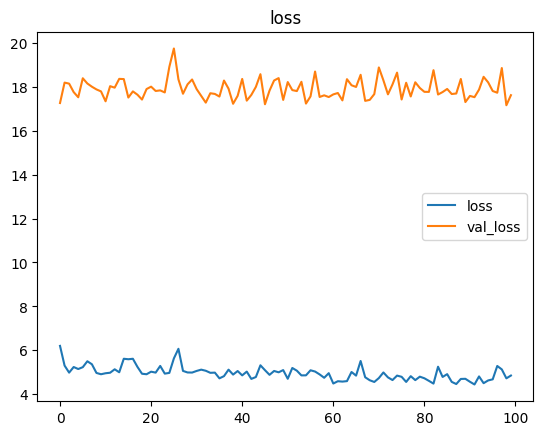

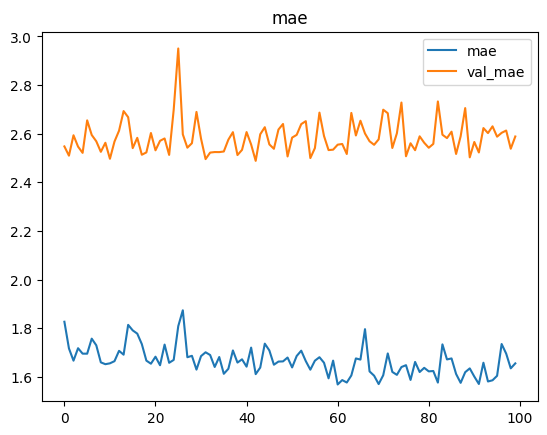

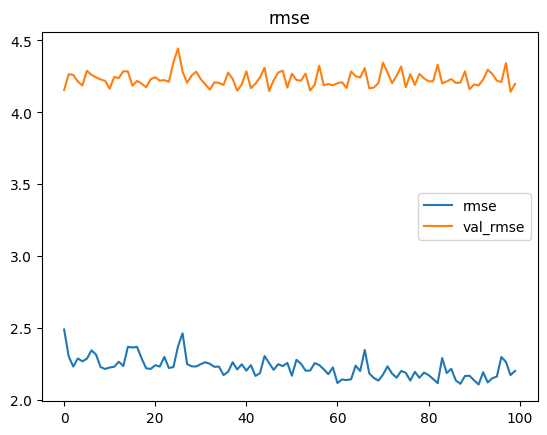

In [38]:
# Apply the custom function to see how your model is doing
plot_history(history)

## Evaluation


In [39]:
train_scores = eval_regression(reg_model4,
                         X_train,
                         y_train,
                         name='reg_model4 Train')
test_scores = eval_regression(reg_model4,
                                       X_test,
                                       y_test,
                                       name='reg_model4 test')
scores = pd.concat([scores, train_scores, test_scores])
scores

4/4 [==============================] - 0s 3ms/step


,MAE,RMSE,R2
reg_model1 Train,5.937423,8.072171,0.265238
reg_model1 Test,5.314461,7.426361,0.212436
reg_model2 Train,2.922909,4.209036,0.800230
reg_model2 test,2.718684,4.110663,0.758700
reg_model3 Train,3.186969,4.672947,0.753766
reg_model3 test,2.830452,4.515749,0.708799
reg_model4 Train,1.558156,2.082715,0.951087
reg_model4 test,2.588498,4.197912,0.748348
